Data description
● city: city this user signed up in
● phone: primary device for this user
● signup_date: date of account registration; in the form ‘YYYYMMDD’
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
● avg_rating_by_driver: the rider’s average rating over all of their trips
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
● surge_pct: the percent of trips taken with surge multiplier > 1
● avg_surge: The average surge multiplier over all of this user’s trips
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
● weekday_pct: the percent of the user’s trips occurring during a weekday

<font size = "5">Part 1 ‑ Exploratory data analysis</font>

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them

In [43]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import numpy as np

In [2]:
df_login = pd.read_json('logins.json')
print(df_login.isnull().sum())

login_time    0
dtype: int64


In [3]:
print(df_login.shape)
df_login.sample(5)

(93142, 1)


,login_time
79739,1970-04-01 01:45:51
91323,1970-04-11 23:37:53
62355,1970-03-16 14:19:46
31496,1970-02-14 02:30:13
59466,1970-03-14 13:01:16


In [4]:
df_login.set_index('login_time', inplace = True)
df_login['count'] = 1

In [5]:
df_login.head(5)

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [6]:
df_login15 = df_login.resample('15min').sum()
df_login15.head(5)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


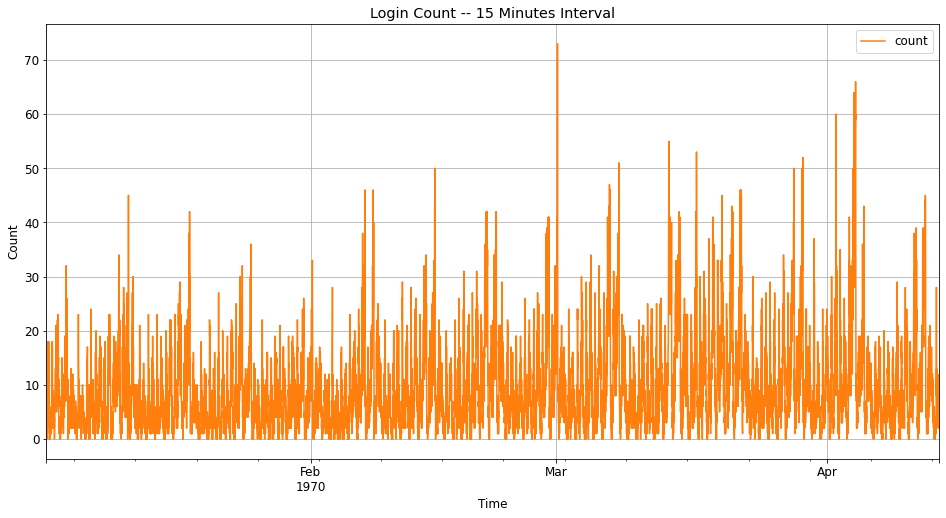

In [7]:
plt.rc('font', size = 12)
fig, ax = plt.subplots(figsize = (16,8))
df_login15['count'].plot(color='tab:orange')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Login Count -- 15 Minutes Interval')
ax.legend()
ax.grid(True)

It doesn't seem like there is a specific trend at 15-minute level. Let's look at the daily level.

In [8]:
df_loginday = df_login.resample('1D').sum()
df_loginday.head()

,count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


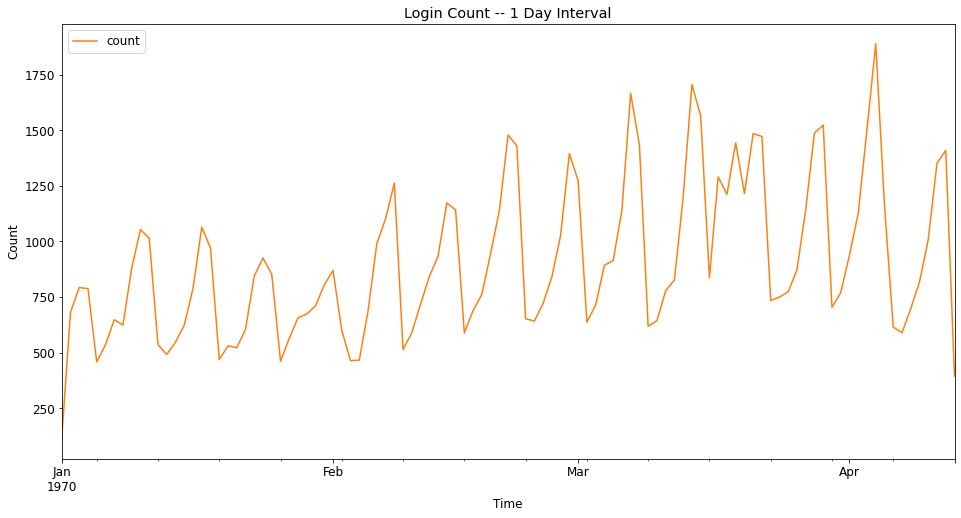

In [9]:
plt.rc('font', size = 12)
fig, ax = plt.subplots(figsize = (16,8))
df_loginday['count'].plot(color='tab:orange')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Login Count -- 1 Day Interval')
ax.legend()

We can see that there is a weekly cycle, so let's put weekday on the xaxis.

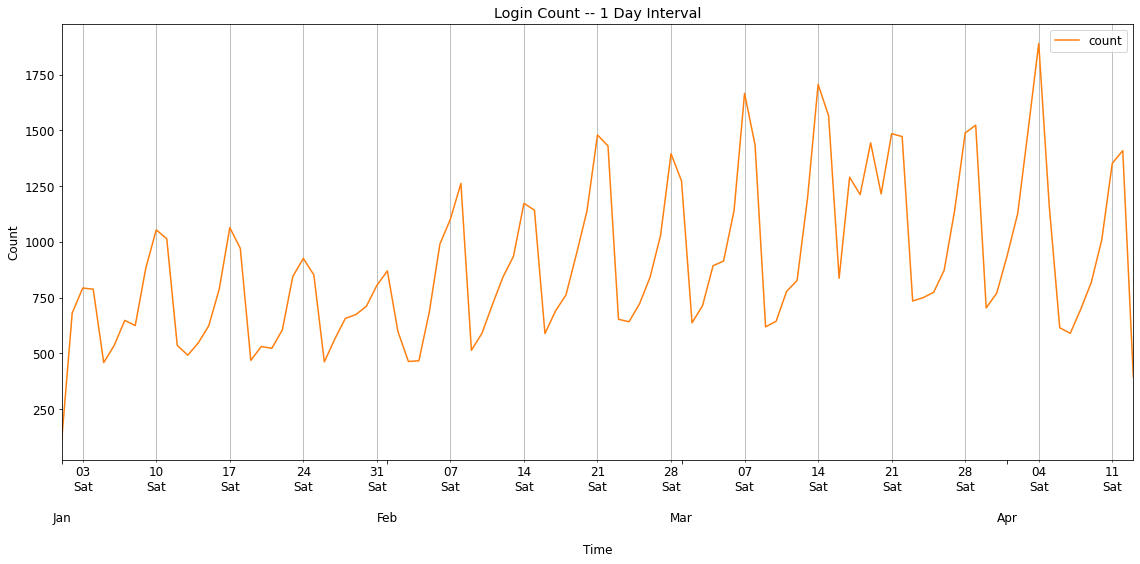

In [10]:
plt.rc('font', size = 12)
fig, ax = plt.subplots(figsize = (16,8))
df_loginday['count'].plot(color='tab:orange')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Login Count -- 1 Day Interval')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(5),interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n'))
ax.xaxis.grid(True, which="minor")
ax.legend()
plt.tight_layout()

We can see the count peaked on weekends. And now let's focus on hourly data to see if there is any hourly trend.

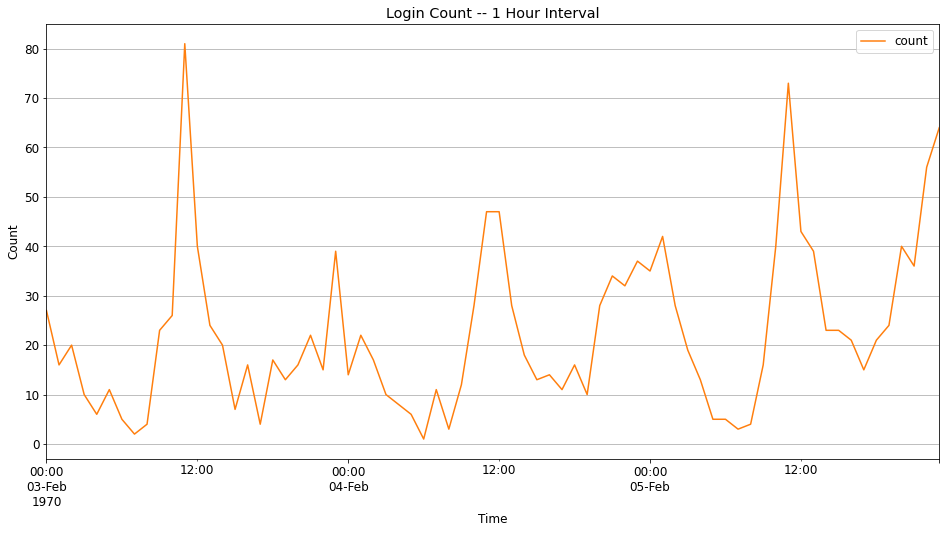

In [11]:
plt.rc('font', size = 12)
fig, ax = plt.subplots(figsize = (16,8))
df_loginhour = df_login.resample('1H').sum()
df_loginhour['count'].loc['1970-02-03':'1970-02-05'].plot(color='tab:orange')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Login Count -- 1 Hour Interval')
ax.yaxis.grid()
ax.legend()

We can tell that count seemed to peak at 12:00 and 00:00. Let's do a heat map to summarize all we've found.

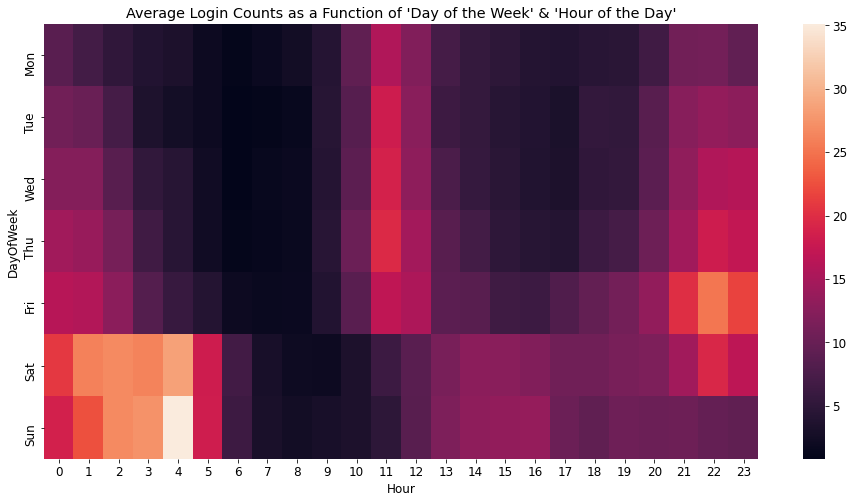

In [12]:
df_reset_index = df_login15.reset_index()
df_reset_index['Day'] = df_reset_index.login_time.dt.day
df_reset_index['Hour'] = df_reset_index.login_time.dt.hour
df_reset_index['DayOfWeek'] = df_reset_index.login_time.dt.dayofweek
login_pivot = pd.pivot_table(df_reset_index, index='DayOfWeek',columns='Hour',values='count',aggfunc='mean')
login_pivot.head(2)
fig, ax = plt.subplots(figsize = (16,8))
ax = sns.heatmap(login_pivot);
ax.set_title("Average Login Counts as a Function of 'Day of the Week' & 'Hour of the Day'");
ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

We have found 2 major trends:
1. Weekly cycle:<br> 
the login counts peaked on weekends.
2. Daily cycle: <br>
      a. Weekends: the login counts started to rise after midnight and peak at 2-3 AM, and the lowest point throughout the day was at 7-10 AM.<br>
      b. Weekdays: the login counts had 2 summits at 11 AM and 22 AM, and the two lowest zone at 6-8 AM and 4-5 PM.

<font size="5">Part 2 ‑ Experiment and metrics design</font>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

**Answer:**

The question has a lot of uncertainty and I would need to make some assumptions, otherwise it's nearly impossible to desgin an experiment. The question stated that the purpose of the experiment is to encourage driver partners to cross the toll bridge by reimbursing toll cost, but I would like to know what's the real purpose. Is the company trying to increase their customer base at the cost of losing profit? Or does the company want to see profit from this encouragment? The answer of that will make a huge differece in how we are going to design the experiment. And here I will assume the company just wants to maximize the revenue regardless of the actual profit.

Also, I am assuming the toll cost is relatively high comparing with what a driver can make from that cost. Otherwise, supply and demand imbalance should already drive the drivers to eat the cost to maximize what they can make. And it's probably safe to assume the reimbusement only occurs once a day, otherwise drivers will be more inclined to pick up intercity trip because drivers will now be double paid by the customer and the company with the toll fee, whcih I believe is not the purpose of the experiment at all. 

Furthermore, for drivers who mainly work on weekdays in each cities probably have their schedule set up to work on the busier time. Otherwise they would've moved to the city that fits their circadian rhythm. Therefore, I am assuming the demand during Gotham night and Metropolis day are really high yet that toll costs are too high to stop drivers from crossing the toll bridge to meet the demand. 

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric? <br>
<br>
I would pick <strong>counts of passenger trips at Gotham night and Metropolis day</strong> as the metric becuase that is the demand we are trying to meet. A successful experiment should see the significant change of that metric, otherwise the company would only lose money on this experiment.


2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats. <br><br>
**a.** I will inform the drivers 2 weeks ahead of the plan. I will also inform them the circadian pattern for both cities so they can best utilize the reimbursement. I also would not provide any reimbursement on weekends assuming supply and demand have reached equilibrium. Neither would I provide toll fee reimbursement for drivers coming into Gotham during day and Metropolis during night because that's simply against what we are trying to accomplish in the experiment.<br><br>
**b.** I will conduct two hypothesis testing and the null hypotheses are as followed:<br> -  There is no reimbursement expense <br>-   The counts of passenger trips during Gotham night and Metropolis day haven't increased respectively. <br><br>
**c.** If both null hypotheses were overthrown, it indicates that the reimbursement plan haas been working and I will recommend to continue the experiment. But meanwhile, we will need to continuously collect data to see how much profit have we gained or lost. We would also need to monitor feedbacks from drivers and customers to see if there is any impact. And if either one of the null hypotheses were not overthrown, we will need to review the data to see what have we done wrong. It could be that we overwhelemed the supply or we made mistakes on some of the assumptions.

<font size = "5">Part 3 ‑ Predictive modeling</font>

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).


Data description
● city: city this user signed up in
● phone: primary device for this user
● signup_date: date of account registration; in the form ‘YYYYMMDD’
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
● avg_rating_by_driver: the rider’s average rating over all of their trips
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
● surge_pct: the percent of trips taken with surge multiplier > 1
● avg_surge: The average surge multiplier over all of this user’s trips
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
● weekday_pct: the percent of the user’s trips occurring during a weekday

In [13]:
df_r = pd.read_json('ultimate_data_challenge.json')
df_r.sample(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
21024,Winterfell,1,2014-01-05,5.0,1.0,2014-01-15,iPhone,0.0,False,100.0,14.16,5.0
44821,Winterfell,0,2014-01-18,4.0,1.0,2014-04-18,iPhone,0.0,False,33.3,1.94,4.8
42445,Winterfell,2,2014-01-25,5.0,1.0,2014-02-16,iPhone,0.0,True,0.0,8.74,5.0
40096,Astapor,0,2014-01-25,5.0,1.0,2014-05-04,Android,0.0,False,50.0,12.81,4.5
31610,Winterfell,2,2014-01-15,4.5,1.0,2014-06-05,iPhone,0.0,True,100.0,12.59,5.0


In [14]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
df_r.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [16]:
print(df_r.phone.value_counts(), '\n')
print(df_r.city.value_counts(),'\n')
print(df_r.ultimate_black_user.value_counts())

iPhone     34582
Android    15022
Name: phone, dtype: int64 

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64 

False    31146
True     18854
Name: ultimate_black_user, dtype: int64


The column 'last_trip_date', 'signup_date' should be datetime object

In [17]:
df_r.last_trip_date = pd.to_datetime(df_r.last_trip_date)
df_r.signup_date = pd.to_datetime(df_r.signup_date)

In [18]:
df_r.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [19]:
df_r['Active'] = df_r['last_trip_date'] >= (df_r.last_trip_date.max() - pd.Timedelta('30 days'))

In [20]:
df_r.sample(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active
46483,King's Landing,1,2014-01-25,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,1.56,5.0,False
4694,Astapor,1,2014-01-19,5.0,1.00,2014-05-07,Android,0.0,True,100.0,1.04,5.0,False
45541,Winterfell,0,2014-01-29,4.7,1.44,2014-03-09,iPhone,75.0,False,0.0,3.42,5.0,False
24392,Astapor,3,2014-01-07,5.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,5.0,False
19347,Winterfell,1,2014-01-07,5.0,1.00,2014-02-01,Android,0.0,False,0.0,1.02,5.0,False


In [21]:
df_r['Active'].sum()/ len(df_r)

0.37608

There are **37.6%** of customers are still retained.

In [22]:
df_r.groupby('Active').mean()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
Active,,,,,,,,
False,1.658482,4.607557,1.075339,8.666739,0.299942,60.647032,6.207939,4.787464
True,3.306318,4.592930,1.073809,9.152797,0.505052,61.389034,5.114788,4.762772


<AxesSubplot:>

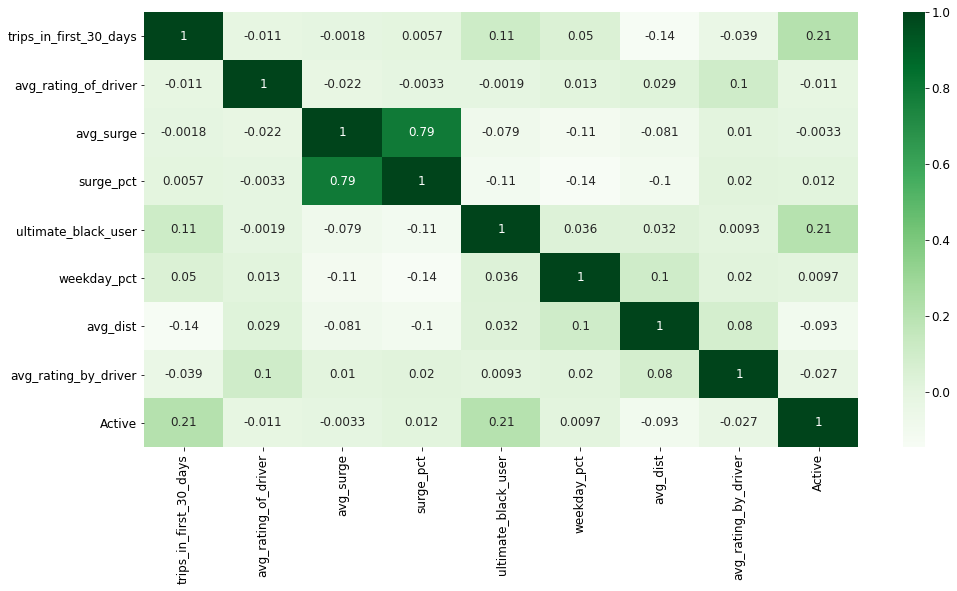

In [23]:
df_r.avg_rating_of_driver = df_r.avg_rating_of_driver.fillna(df_r.avg_rating_of_driver.mean())
df_r.avg_rating_by_driver = df_r.avg_rating_by_driver.fillna(df_r.avg_rating_by_driver.mean())  
fig, ax = plt.subplots(figsize = (16,8))
sns.heatmap(df_r.corr(), annot = True,  cmap="Greens")

We can see that **trips_in_first_30_days** and **ultimate_black_user** were the most posititvely related variables. **Avg_dist** was the most negatively related variable. And now let's look at the non-numeric columns.

In [24]:
print(df_r.city.value_counts(), "\n", df_r.city.isnull().sum(),"\n")
print(df_r.phone.value_counts(), "\n", df_r.phone.isnull().sum())

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64 
 0 

iPhone     34582
Android    15022
Name: phone, dtype: int64 
 396


In [25]:
# Fill the null value in phone column with N/A
df_r.phone.fillna('N/A', inplace = True)

Now we can do one-hot-code on city and phone columns.

In [26]:
cities = pd.get_dummies(df_r['city'], prefix= 'city', drop_first = True)
phones = pd.get_dummies(df_r['phone'], prefix = 'phone', drop_first = True)
df_r = df_r.join(cities).join(phones)
df_r.drop(['city','phone'], axis=1, inplace = True)

In [27]:
df_r.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_N/A,phone_iPhone
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.202600,0.466720,0.007920,0.691640
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753,0.401941,0.498896,0.088642,0.461821
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,0.000000,1.000000,0.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

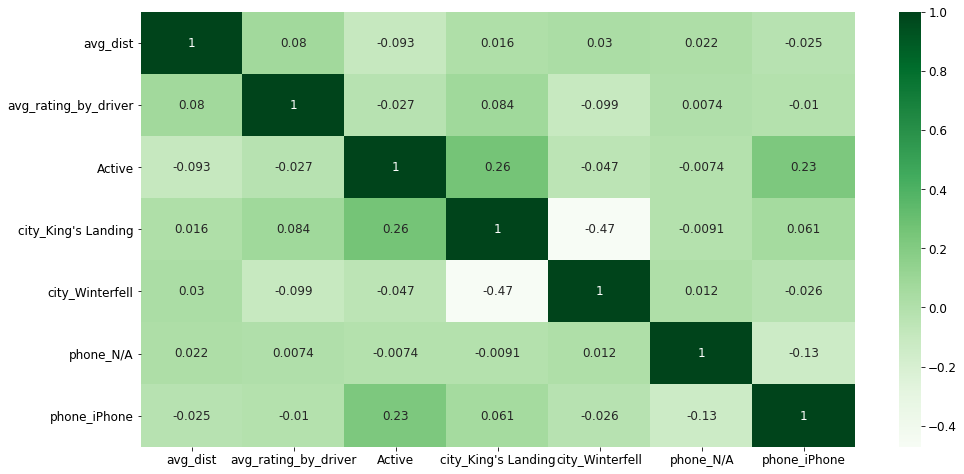

In [28]:
fig, ax = plt.subplots(figsize = (16,8))
sns.heatmap(df_r.iloc[:, -7:].corr(), annot = True, cmap="Greens")

**city_King's Landing** and **phone_iPhone** were the most positively related variables. 

I will use 6 classification algorithms to predict retention: <br>LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, NaiveBayesClassifier

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.naive_bayes import GaussianNB

In [29]:
# score table for all classification models
class_index = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GradientBoostingClassifier','NaiveBayes']
score_df = pd.DataFrame(index = class_index, columns= ['accuracy_train','f1_score_train','accuracy_test','f1_score_test'])

# calculate and print the result
def log_result(algo, pred_train, pred_test):
    """compute and log the performance for both training and test sets"""
    
    # compute the performance  
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    # log the performance
    score_df.loc[algo,:] = accuracy_train, f1_train, accuracy_test, f1_test
    
    # compute confusion matrix and print
    print("Classification results based on the testset:\n", classification_report(y_test, pred_test))

In [31]:
X = df_r.drop('Active', axis=1)
# Drop two dates columns that can't contribute to modeling
X.drop(['signup_date', 'last_trip_date'], axis =1, inplace = True)
y = df_r.Active

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.25, random_state = 42)

1. Logistic Regression

In [33]:
LR = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])
LR.fit(X_train, y_train)
log_result("LogisticRegression", LR.predict(X_train), LR.predict(X_test))

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.74      0.85      0.79      7799
        True       0.67      0.50      0.57      4701

    accuracy                           0.72     12500
   macro avg       0.70      0.67      0.68     12500
weighted avg       0.71      0.72      0.71     12500



2. Decision Tree

In [34]:
DT = DecisionTreeClassifier(class_weight = 'balanced', min_weight_fraction_leaf=0.01)
DT.fit(X_train, y_train)
log_result("DecisionTreeClassifier", DT.predict(X_train), DT.predict(X_test))

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.82      0.80      0.81      7799
        True       0.67      0.70      0.69      4701

    accuracy                           0.76     12500
   macro avg       0.75      0.75      0.75     12500
weighted avg       0.76      0.76      0.76     12500



3. Random Forest

In [35]:
RF = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier(class_weight = 'balanced'))])
RF.fit(X_train, y_train)
log_result("RandomForestClassifier", RF.predict(X_train), RF.predict(X_test))

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.80      0.82      0.81      7799
        True       0.69      0.65      0.67      4701

    accuracy                           0.76     12500
   macro avg       0.74      0.74      0.74     12500
weighted avg       0.76      0.76      0.76     12500



4. SVC

In [36]:
SVC = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
SVC.fit(X_train, y_train)
log_result("SVC", SVC.predict(X_train), SVC.predict(X_test))        

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.78      0.87      0.82      7799
        True       0.73      0.59      0.65      4701

    accuracy                           0.76     12500
   macro avg       0.76      0.73      0.74     12500
weighted avg       0.76      0.76      0.76     12500



5. Gradient Boosting

In [82]:
GBC = Pipeline([('scaler', StandardScaler()), ('GBC', GradientBoostingClassifier())])
GBC.fit(X_train, y_train)
log_result("GradientBoostingClassifier", GBC.predict(X_train), GBC.predict(X_test))

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.81      0.86      0.84      7799
        True       0.74      0.67      0.71      4701

    accuracy                           0.79     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.79      0.79      0.79     12500



6. Naive Bayes

In [38]:
NB = Pipeline([('scaler', StandardScaler()), ('NB', GaussianNB())])
NB.fit(X_train, y_train)
log_result("NaiveBayes", NB.predict(X_train), NB.predict(X_test))

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.79      0.73      0.76      7799
        True       0.60      0.69      0.64      4701

    accuracy                           0.71     12500
   macro avg       0.70      0.71      0.70     12500
weighted avg       0.72      0.71      0.71     12500



In [40]:
score_df

,accuracy_train,f1_score_train,accuracy_test,f1_score_test
LogisticRegression,0.718027,0.570302,0.71656,0.568401
DecisionTreeClassifier,0.761573,0.690291,0.76128,0.68949
RandomForestClassifier,0.996853,0.995815,0.75832,0.670233
SVC,0.775333,0.668477,0.76472,0.652487
GradientBoostingClassifier,0.78896,0.703039,0.78944,0.705527
NaiveBayes,0.711013,0.639763,0.71184,0.642162


The gradient boosting seems to provide the best performance so we will pick it for graid search.

In [92]:
param = {
    "GBC__loss":["deviance"],
    "GBC__learning_rate": [0.001, 0.01, 0.01, 0.1, 0.2],
    "GBC__max_depth":[5,8,11],
    "GBC__max_features":["log2","sqrt"],
    "GBC__n_estimators":[100, 200, 300]
    }
GBC_CV = GridSearchCV(GBC, param, scoring = 'accuracy', cv=5, verbose = 1)
GBC_CV.fit(X_train, y_train)
print(GBC_CV.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'GBC__learning_rate': 0.1, 'GBC__loss': 'deviance', 'GBC__max_depth': 5, 'GBC__max_features': 'sqrt', 'GBC__n_estimators': 200}


In [99]:
# Update model with the best parameters
GBC = Pipeline([('scaler', StandardScaler()), 
                ('GBC', GradientBoostingClassifier(learning_rate= 0.1, loss= 'deviance', max_depth= 5, 
                                                   max_features= 'sqrt',n_estimators= 200))])
GBC.fit(X_train, y_train)
log_result("GradientBoostingClassifier", GBC.predict(X_train), GBC.predict(X_test)) 

Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.82      0.86      0.84      7799
        True       0.75      0.68      0.71      4701

    accuracy                           0.79     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.79      0.79      0.79     12500

accuracy_train    0.81104
f1_score_train    0.73532
accuracy_test      0.7928
f1_score_test     0.71042
Name: GradientBoostingClassifier, dtype: object


In [101]:
print(score_df.loc['GradientBoostingClassifier'])

accuracy_train    0.81104
f1_score_train    0.73532
accuracy_test      0.7928
f1_score_test     0.71042
Name: GradientBoostingClassifier, dtype: object


In [104]:
Variables = pd.DataFrame({'feature': X_train.columns, 'weight':GBC.named_steps.GBC.feature_importances_})
Variables.sort_values(by='weight', ascending = False)

,feature,weight
7,avg_rating_by_driver,0.179222
8,city_King's Landing,0.151623
5,weekday_pct,0.139653
3,surge_pct,0.115842
0,trips_in_first_30_days,0.100408
2,avg_surge,0.086326
11,phone_iPhone,0.076455
4,ultimate_black_user,0.065988
6,avg_dist,0.039991
1,avg_rating_of_driver,0.024458


From the information of the features weight:<br>


**avg_rating_by_driver** was the most important indicator in the prediction of user retention. Ultimate can advertise things like the following "We will provide $5 credit for clients who get good rating from our drivers!" 

**city_King's Landing** was the second most important indicator. Ultimate should investigate what's difference between these cities and see if there is anything that the company can work on. 

**weekday_pct** was also and important indicator. The company may try to attract people to use the ride service during the weekday to find more clients who would need that service on the weekday.